[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/0-Spectral-Background.ipynb).

# Spectral Theory: From Graph Laplacian and its eigenfunctions, to Heat Kernal and Commute Times

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/0-Spectral-Background.ipynb).

Francisco Escolano, ELLIS Alicante UNIT 

In [18]:
# Interesting color use: https://github.com/binodbhttr/mycolorpy/blob/master/usage_example.ipynb
!pip install mycolorpy

## The Graph Laplacian and its Eigenfunctions

64


/usr/local/lib/python3.7/dist-packages/mycolorpy/colorlist.py:93: RuntimeWarning: invalid value encountered in double_scalars
  norm=(c-data_min)/(data_max-data_min)*0.99


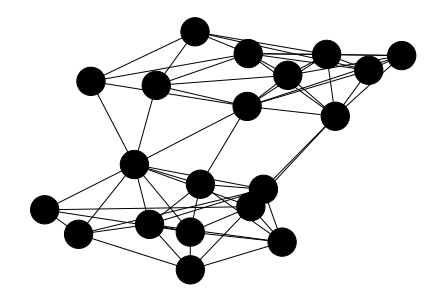

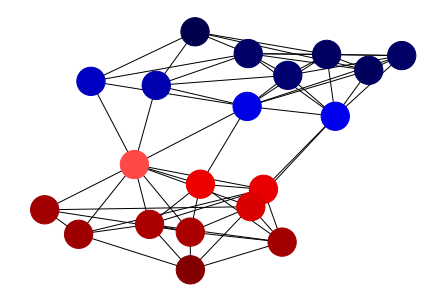

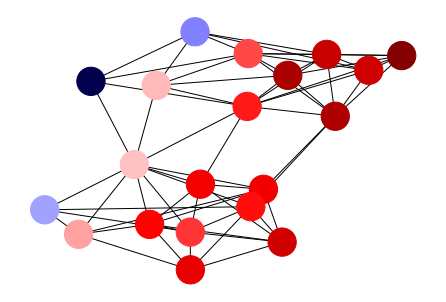

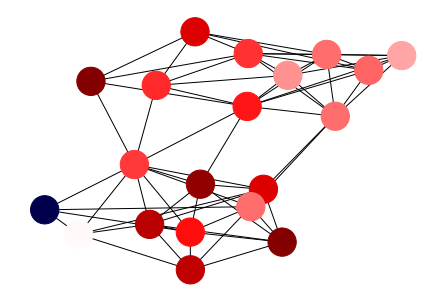

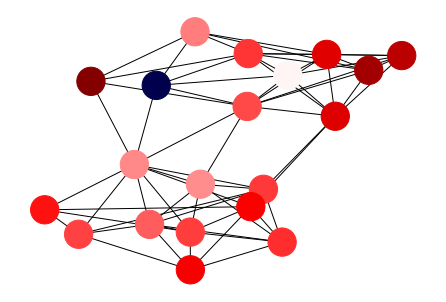

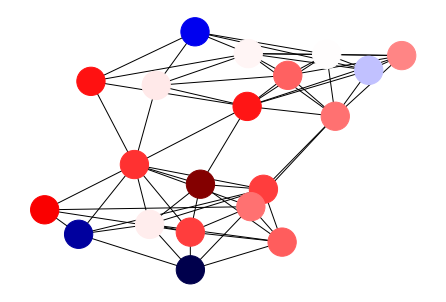

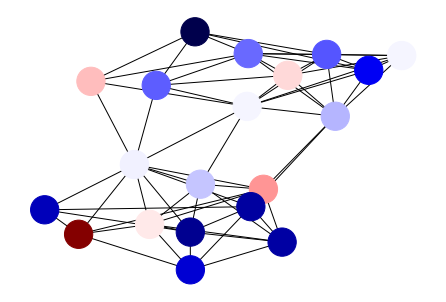

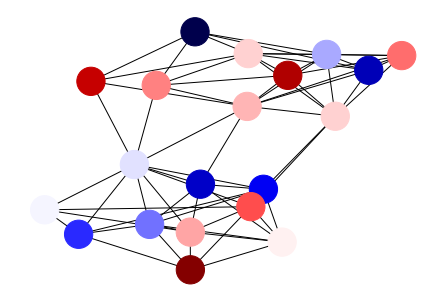

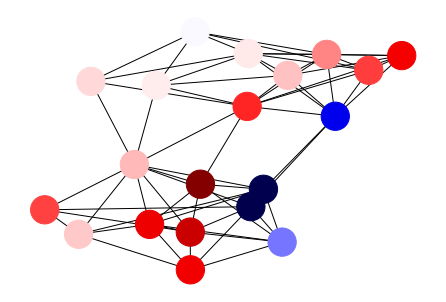

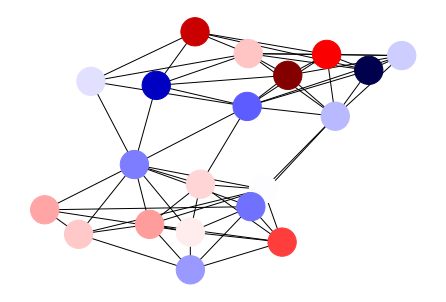

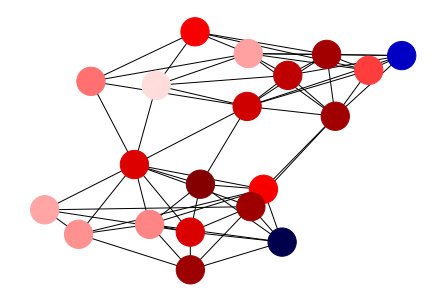

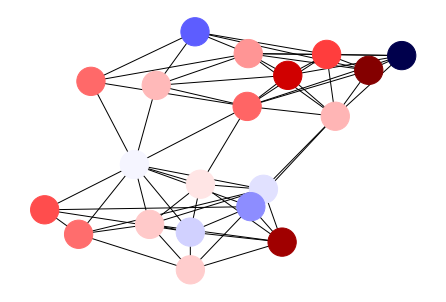

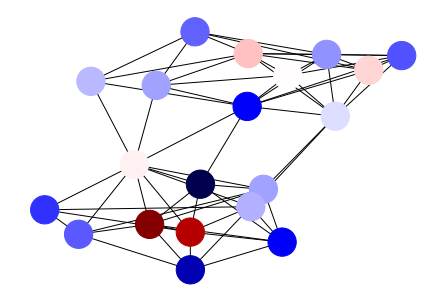

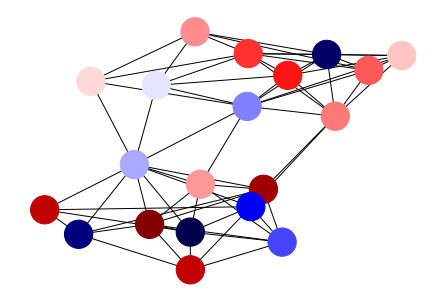

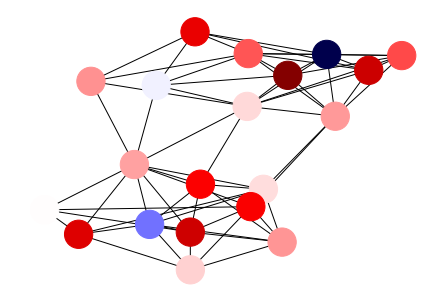

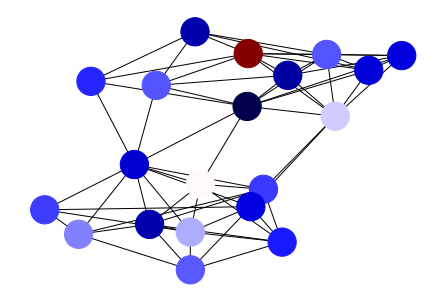

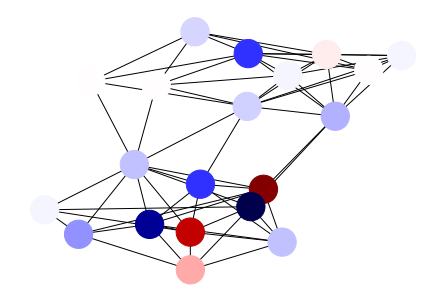

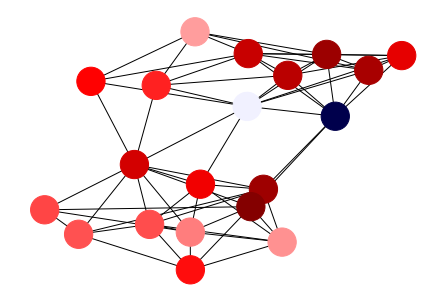

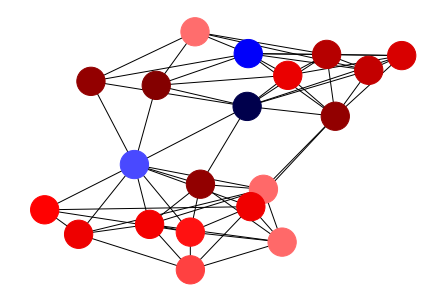

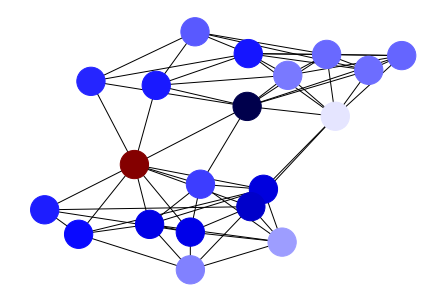

In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm
from mycolorpy import colorlist as mcp

# Plot the k-th Laplacian Eigenvalue on the Graph
def plot_eigenvector_over_graph(G,evecs,k):
  # Extract eigenvector from the evecs matrix and transform into dim (n,)
  u = np.real(evecs[:,k])
  u = np.transpose(u)
  u2 = np.squeeze(u)
  v = np.zeros(u2.shape[1])
  for i in range(u2.shape[1]):
    # Add 100 to overcome negative values
    v[i] = u2[0,i] + 100
    
  # Create the color map 
  vColor =mcp.gen_color_normalized(cmap="seismic",data_arr=v)
  pos = nx.spring_layout(G,seed=63)  # Seed layout for reproducibility
  # Draw the graph
  nx.draw(G, pos, node_color=vColor, node_size=800, cmap=plt.cm.Blues)
  plt.show()

# Plot the labels of uB and uD on the Graph
def plot_Dirichlet_labels_over_graph(G,idxB,idxD,uB,uD):
  u = np.zeros(G.number_of_nodes())
  # Store the values in uB and then uD
  for i in range(uB.shape[0]):
    u[idxB[i]]=uB[i]*100
    print(u[idxB[i]])
  for j in range(uD.shape[1]):
    u[idxD[j]]=uD[0,j]*100
  print('u is',u)
  print('uD[0,:]', uD[0,:])
  # Create the color map 
  vColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  pos = nx.spring_layout(G,seed=63)
  # Draw the graph
  nx.draw(G, pos, node_color=vColor, node_size=800, cmap=plt.cm.Blues)
  plt.show()


# Start to work on the graphs 

G = nx.barbell_graph(10,0)
sizes = [10, 10]
probs = [[0.75, 0.05], [0.05, 0.75]]
G = nx.stochastic_block_model(sizes, probs, seed=0)
#nx.draw_networkx_nodes(G,pos=nx.spring_layout(G))
#nx.draw(G)
#L = nx.normalized_laplacian_matrix(G)
A = nx.adjacency_matrix(G)
L = nx.laplacian_matrix(G)
# Finding eigen values and eigen vectors
e, evecs = np.linalg.eig(L.todense())
e.shape, evecs.shape

# Sort them (both e's and evecs's) ascending
idx =e.argsort()
e = e[idx]
evecs = evecs[:,idx]
print(G.size())
# Some plots 
for k in range(G.number_of_nodes()):
  plot_eigenvector_over_graph(G,evecs,k)  
  

[877 889 432 265  90 563 353 532 991 463 493 404  64 876 753 515 894  97
 984 370 506 475 589 317 246 753 744 387 270 970 516 930 323 928 256 472
 241 144 676 746 482 285 786 648 755 898 200 405 477 674 440 707 962  13
 122 417  52 987 655 867 245 971 833 323 378 997 662 837  26 325 729 411
 829 453 639 100 771 255  16 277 532 529  56 731 899 916 147 188 833 271
 790 258 950 572 746 528 642  71 459 772 548   1 142 840 932 547 694 670
 602 992 319 701 962 587 446 363 784 784 224 643 566 747 724 634 479 841
 840 612 391  62 153 269  44 339 232 882  38 690 619 887  89 917 468 959
 510 113 678 990  84 736 473 831 662 470 968 453 363  52 122 963 382 115
 263 894 838 639 903 192 935 776 346  34 419 508 121 234 966 476 463 705
  95 640 783 406 699 111 766 861 816 145 649 427 794 329 641 416 816 110
 978 162]
(200,)


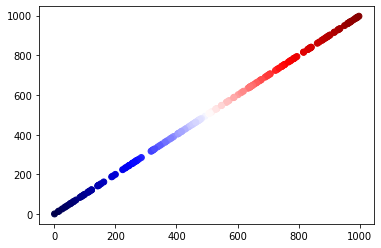

In [20]:
a=np.random.randint(1000, size=(200))
a=np.array(a)
print(a)
color1=mcp.gen_color_normalized(cmap="seismic",data_arr=a)
plt.scatter(a,a,c=color1)
print(a.shape)

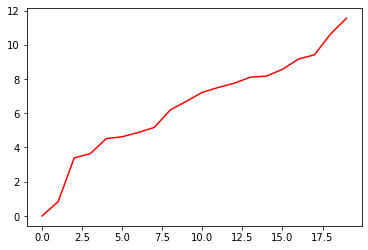

In [21]:
def plot_eigenvalues(input_list):  
  x = range(len(input_list))
  y = np.asarray(input_list)
  plt.plot(x,y, 'r')
  # show the plot
  plt.show()
plot_eigenvalues(list(e))

## 2. The Dirichlet Integral for Semi-Supervised Learning

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
[ 0 19]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[[ 6  0  0 -1 -1 -1 -1  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 -1  0 -1 -1  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  4  0  0  0 -1 -1  0 -1  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  6 -1 -1 -1 -1  0  0  0  0 -1  0  0  0  0  0  0  0]
 [-1 -1  0 -1  7 -1  0 -1  0 -1  0  0  0  0 -1  0  0  0  0  0]
 [-1 -1  0 -1 -1  7 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0 -1 -1  0 -1  7 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1 -1 -1 -1 -1 -1 10  0 -1  0  0 -1 -1  0  0  0  0 -1  0]
 [-1 -1  0  0  0 -1 -1  0  5 -1  0  0  0  0  0  0  0  0  0  0]
 [-1  0 -1  0 -1  0 -1 -1 -1  7  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  7 -1 -1  0 -1 -1 -1 -1  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0 -1  8  0 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0 -1  0  0  0 -1  0  0 -1  0  9 -1 -1 -1 -1 -1 -1  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0 -1 -1  4  0

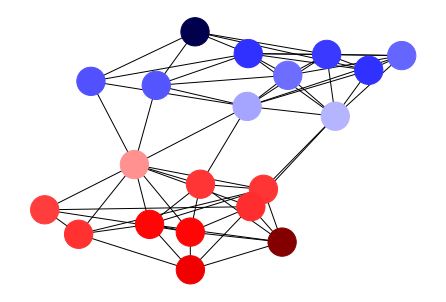

In [22]:
# Dirichlet Integral and Random Walker
idxAll = set(range(G.number_of_nodes()))
idxB = set([0, 19])
idxD = set([x for x in idxAll if x not in idxB])
print(idxAll)

idxB = np.array(list(idxB))
idxD = np.array(list(idxD))
print(idxB)
print(idxD)
Ldense = L.todense()
print(Ldense)
LdenseD = Ldense[idxD,:]
LdenseD = LdenseD[:,idxD]
print(LdenseD)

print(idxD.shape[0])
print(idxB.shape[0])
print(np.zeros((2,2)))
Bdense = np.zeros((idxB.shape[0],idxD.shape[0]))
print(Ldense.shape)
Bdense = Ldense[idxB,:]
Bdense = Bdense[:,idxD]
print(Bdense)

Inv = np.matmul(np.linalg.inv(LdenseD),-np.transpose(Bdense))
print("inv",Inv)
uB = np.array([1,0])
uD = np.matmul(Inv,np.transpose(uB))
print(uD)
print(uD.shape)
plot_Dirichlet_labels_over_graph(G,idxB,idxD,uB,uD)



## 3. Heat Kernels and Graph Diffusion

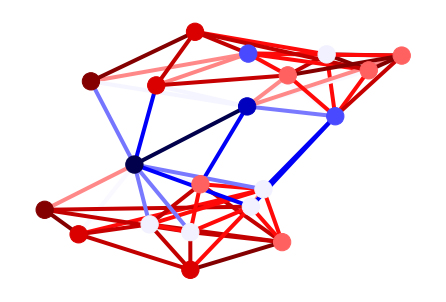

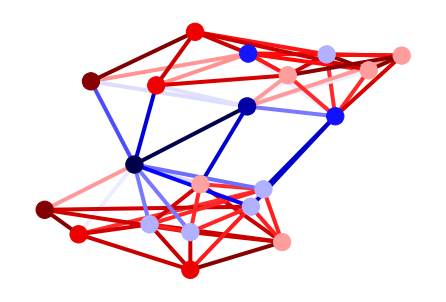

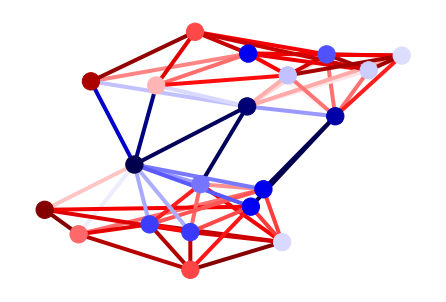

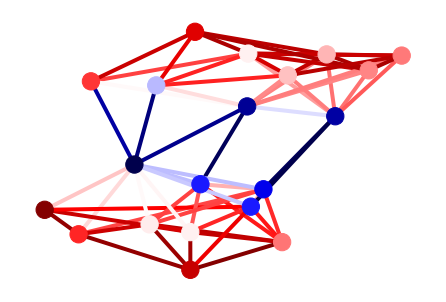

In [23]:
# Heat Kernels
def heat_kernel(G,e, evecs,beta):
  n = G.number_of_nodes()
  H = np.zeros((n,n))
  Phi = evecs
  Lambda = np.diag(np.exp(-beta*e))
  H = np.matmul(Phi,Lambda)
  H = np.matmul(H,np.transpose(Phi))
  return H

# Plot the beta-th Heat Kernel on the Graph
def plot_beta_heat_kernel_over_graph(G,e,evecs,beta):
  # Extract the heat kernel
  H = heat_kernel(G,e,evecs,beta)
  # From the heat kernel extract the colors of the edges
  E = G.edges()
  u = np.zeros(G.number_of_edges())
  k = 0 
  for e in E: 
    i = e[0]
    j = e[1]
    u[k] = H[i,j]*100 
    k = k + 1
  # And also those of the nodes
  V = G.nodes()
  n = np.zeros(G.number_of_nodes())
  l = 0
  for v in V: 
    n[l] = H[l,l]*100
    l = l + 1    
  # Create the color maps 
  eColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  nColor =mcp.gen_color_normalized(cmap="seismic",data_arr=n)
  pos = nx.spring_layout(G,seed=63)
  options = {
    "node_color": nColor, #"#A0CBE2",
    "edge_color": eColor,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
  }
  # Draw the graph
  nx.draw(G, pos, **options)
  plt.show()
"""
H1 = heat_kernel(G,e,evecs,beta=1)
print(H1.shape)
plt.imshow(H1*(A.todense()), alpha=0.8, cmap="seismic")
print(A.todense())
#plt.imshow(np.diag(e), alpha=0.8, cmap="seismic") 
"""

# Plot the beta-th Heat Kernel on the Graph
def plot_beta_heat_kernel_trace(G,e,evecs,node, color):
  HKS_list = []
  betar = 0.001
  beta = 0
  for k in range(1000):
     H = heat_kernel(G,e,evecs,beta)
     HKS_list.append(H[node,node])
     beta = beta + betar
  x = range(len(HKS_list))
  y = np.asarray(HKS_list)
  plt.plot(x,y, color)
  # show the plot
  plt.show()


plot_beta_heat_kernel_over_graph(G,e,evecs,beta=0.01)
plot_beta_heat_kernel_over_graph(G,e,evecs,beta=0.1)
plot_beta_heat_kernel_over_graph(G,e,evecs,beta=0.5)
plot_beta_heat_kernel_over_graph(G,e,evecs,beta=1)

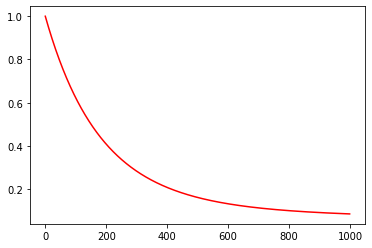

In [24]:
# Plot HKS: a node inside a community looses slowly its heat
plot_beta_heat_kernel_trace(G,e,evecs,node=1,color='r')

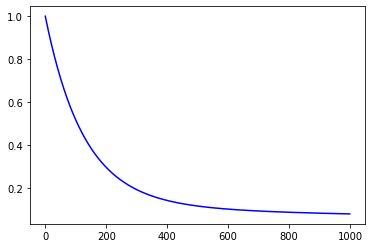

In [25]:
# Plot HKS: a node in between communities looses its heat faster
plot_beta_heat_kernel_trace(G,e,evecs,node=10, color='b')

## 4. Commute Times and their Embedding

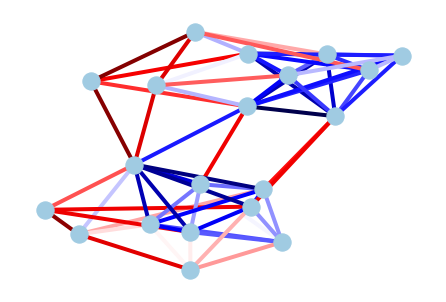

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 3.1350152   3.17226804  3.13948623  2.0971876   2.16718947  3.00086075
   3.02403633  1.36778148  3.53070043  2.36597698 -3.13189235 -3.07894649
  -1.8671919  -2.18970446 -1.78279255 -3.15813215 -2.97017763 -3.09689393
  -2.3771849  -3.34758616]
 [ 0.93417601 -0.59335244 -1.73465488  0.51573067  0.566804    0.3672329
   0.05778257 -0.80522365  0.65008056  0.28129862  1.0344912  -0.08297642
   0.2256882  -4.25828005  1.3467432   0.93588806  1.39052559  1.85781922
  -0.7514071  -1.93836628]]


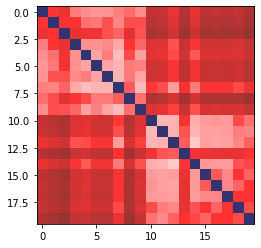

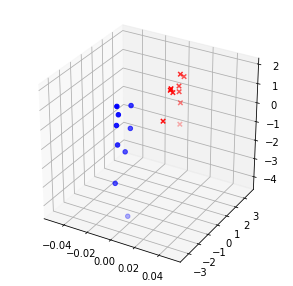

In [26]:
# Commute Times Embedding
from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def graph_vol(G):
  A = nx.adjacency_matrix(G)
  D = A.sum(axis=1)
  D = D.squeeze()
  d = np.zeros(G.number_of_nodes())
  for i in range(G.number_of_nodes()):
    d[i] = D[0,i]
  vol = d.sum()
  return vol

def commute_times_embedding(G,e, evecs):
  n = G.number_of_nodes()
  vol = graph_vol(G)
  A = nx.adjacency_matrix(G)
  D = A.sum(axis=1)
  Phi = evecs
  Lambda = np.diag(e)
  Lambda = fractional_matrix_power(Lambda, -0.5)
  Lambda[0,0] = 0
  CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
  # Embedding is in the columns
  return CTE

# Plot the CT distance on the Graph
def plot_commute_times_over_graph(G,e,evecs):
  # Extract the embedding
  CTE = commute_times_embedding(G,e, evecs)
  # Embedding is in the columns and we move it to the rows
  CT = pdist(np.transpose(CTE), 'euclidean')
  CT = squareform(CT)
  # From the commute times extract the colors of the edges
  E = G.edges()
  u = np.zeros(G.number_of_edges())
  k = 0 
  for e in E: 
    i = e[0]
    j = e[1]
    u[k] = CT[i,j]*100 
    k = k + 1   
  # Create the color map
  eColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  pos = nx.spring_layout(G,seed=63)
  options = {
    "node_color": "#A0CBE2",
    "edge_color": eColor,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
  }
  # Draw the graph
  nx.draw(G, pos, **options)
  plt.show()

plot_commute_times_over_graph(G,e,evecs)

CTE = commute_times_embedding(G,e, evecs)
CT = pdist(np.transpose(CTE), 'euclidean')
CT = squareform(CT)
plt.imshow(CT, alpha=0.8, cmap="seismic")
#plt.imshow(CTE[:3,:], alpha=0.8, cmap="seismic")
print(CTE[:3,:])

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
xs1 = CTE[0,:10] 
ys1 = CTE[1,:10]
zs1 = CTE[2,:10]
ax.scatter(xs1,ys1,zs1, marker="x", c="red")
xs2 = CTE[0,11:20] 
ys2 = CTE[1,11:20]
zs2 = CTE[2,11:20]
ax.scatter(xs2,ys2,zs2, marker="o", c="blue")
plt.show()

20


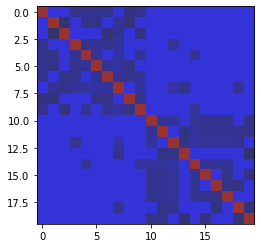

In [27]:
# Commute Times as an optimzation problem 
NL = nx.normalized_laplacian_matrix(G)
NLdense = NL.todense()
plt.imshow(NLdense, alpha=0.8, cmap="seismic")
# Finding eigen values and eigen vectors
eNL, evecsNL = np.linalg.eig(NLdense)
# Sort them (both e's and evecs's) ascending
idx =eNL.argsort()
eNL = eNL[idx]
evecsNL = evecsNL[:,idx]
print(eNL.size)

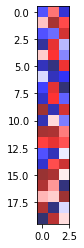

In [54]:
# Let Z be the CT Embedding
# Initialize (first row with Zeros)
n = nx.number_of_nodes(G)
Z = np.zeros((1,3))
# Deterministic initialization
Z = np.concatenate((Z,np.ones((n-1,3))),axis = 0)
# Random initialization
Z = np.random.rand(n,3)
plt.imshow(Z, alpha=0.8, cmap="seismic")

def optimizing_commute_times_cost_function(Z,NLdense, lambdaReg):
  return np.trace(np.matmul(np.matmul(np.transpose(Z),NLdense),Z)) + lambdaReg*np.linalg.norm(np.matmul(np.transpose(Z),Z)-np.eye(Z.shape[1])) #+ lambdaReg*np.linalg.norm(np.matmul(Z,np.transpose(Z))-np.eye(Z.shape[0]))

mu = 0.01
lambdaReg =0.1
cost_list=[]
embedding_list = []
embedding_list.append(Z)
maxiter = 1000
for i in range(maxiter):
  grad = 2*np.matmul(NLdense,Z) + lambdaReg*4*np.matmul(Z,np.matmul(np.transpose(Z),Z)-np.eye(Z.shape[1]))  #+ lambdaReg*4*np.matmul(np.transpose(Z),np.matmul(Z,np.transpose(Z))-np.eye(Z.shape[0]))
  Z = Z - mu*grad
  cost_list.append(optimizing_commute_times_cost_function(Z,NLdense,lambdaReg))
  embedding_list.append(Z)

regularization cost 1.287103355202648


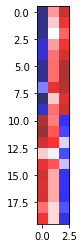

In [55]:
plt.imshow(Z, alpha=0.8, cmap="seismic")
#plot_commute_times_over_graph(G,eNL,evecsNL)
print('regularization cost', np.linalg.norm(np.eye(Z.shape[1])-np.matmul(np.transpose(Z),Z)))

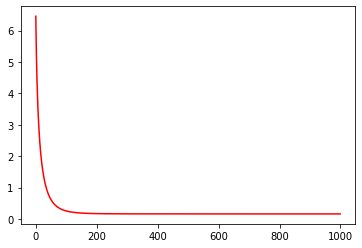

In [29]:
# plot the function
x = range(maxiter)
y = np.asarray(cost_list)
plt.plot(x,y, 'r')

# show the plot
plt.show()

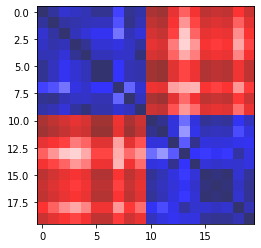

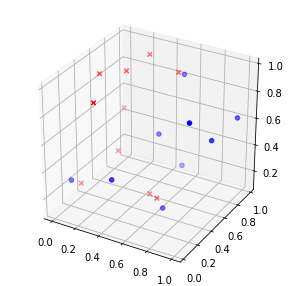

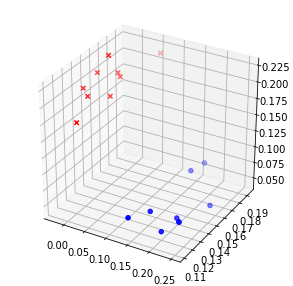

In [30]:
CTZ = pdist(Z, 'euclidean')
CTZ = squareform(CTZ)
plt.imshow(CTZ, alpha=0.8, cmap="seismic")

def plot_optimized_commute_time_embedding(Z):
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(111, projection='3d')
  xs1 = Z[:10, 0] 
  ys1 = Z[:10, 1]
  zs1 = Z[:10, 2]
  ax.scatter(xs1,ys1,zs1, marker="x", c="red")
  xs2 = Z[11:20, 0] 
  ys2 = Z[11:20, 1]
  zs2 = Z[11:20, 2]
  ax.scatter(xs2,ys2,zs2, marker="o", c="blue")
  plt.show()

# After First iteration
plot_optimized_commute_time_embedding(embedding_list[0])
# Finally...
plot_optimized_commute_time_embedding(Z) 


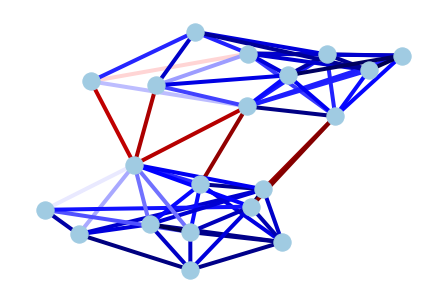

In [31]:
# Plot the optimized CT distance on the Graph
def plot_optimized_commute_times_over_graph(G,Z):
  # Embedding is given by Z
  # Embedding is in the columns and we move it to the rows
  CT = pdist(Z, 'euclidean')
  CT = squareform(CT)
  # From the commute times extract the colors of the edges
  E = G.edges()
  u = np.zeros(G.number_of_edges())
  k = 0 
  for e in E: 
    i = e[0]
    j = e[1]
    u[k] = CT[i,j]*100 
    k = k + 1   
  # Create the color map
  eColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  pos = nx.spring_layout(G,seed=63)
  options = {
    "node_color": "#A0CBE2",
    "edge_color": eColor,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
  }
  # Draw the graph
  nx.draw(G, pos, **options)
  plt.show()

plot_optimized_commute_times_over_graph(G,Z)

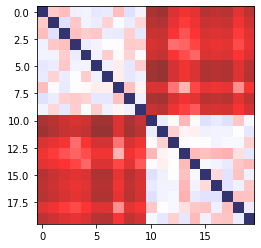

In [32]:
# Commute Times as a NullSpace
NLpinv = np.linalg.pinv(NLdense) 
CTpinv = np.zeros((n,n))
for i in range(n):
  for j in range(n):
    CTpinv[i,j] = graph_vol(G)*(NLpinv[i,i] + NLpinv[j,j] - 2*NLpinv[i,j])
plt.imshow(CTpinv, alpha=0.8, cmap="seismic")

## 5. Graph Debiasing

[[10  0]
 [ 0 10]]
[[10  0]
 [ 0 10]]
[[10  0]
 [ 0 10]]
[[ 0 10]
 [10  0]]
[[9.42049783e-01 1.44287093e-04 9.68829595e-05 9.56208502e-03
  9.51530644e-03 9.56255872e-03 9.56240176e-03 2.35350123e-04
  9.60934357e-03 9.51530568e-03 4.77293975e-07 3.22281973e-07
  4.81962625e-05 9.49827617e-07 9.43582537e-05 4.77289287e-07
  4.79641556e-07 4.78465774e-07 9.48649477e-07 7.93586283e-09]]


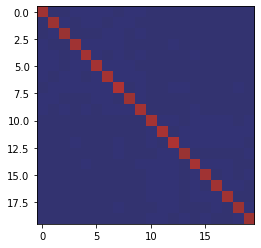

In [33]:
# Debiasing if necessary
from sklearn.metrics import confusion_matrix

def find_errors(CT): 
  n = int(CT.shape[0]/2)
  CTZ = np.copy(CT)

  # Fill diagonal with +Inf
  for i in range(2*n):
    CTZ[i,i] = 9999
  
  y_true = np.concatenate((np.ones((1,n)),np.zeros((1,n))),axis = 1)
  y_pred = np.zeros((1,2*n))
  for i in range(2*n):
    ithrow = CTZ[i,:]
    nearest_idx = np.unravel_index(np.argmin(ithrow, axis=None),shape=ithrow.shape)[0]
    if i < n:
      if nearest_idx < n:
        y_pred[0,i] = 1
      else: 
        y_pred[0,i] = 0
    else:
      if nearest_idx >= n:
        y_pred[0,i] = 0
      else: 
        y_pred[0,i] = 1
  return confusion_matrix(y_true[0], y_pred[0])

print(find_errors(CTZ))
print(find_errors(CTpinv))
print(find_errors(CT))
HK = heat_kernel(G,e,evecs,beta=0.01)
print(find_errors(HK))
print(HK[0,:])
plt.imshow(HK, alpha=0.8, cmap="seismic")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[ 9.17916514e-05 -6.73021332e-04  0.00000000e+00  2.13987334e-02
   1.99615721e-02  2.84602657e-03  2.37022429e-03  3.63736809e-02
  -8.03175609e-03  1.58803991e-02  1.28753464e-01  1.27666468e-01
   1.02788748e-01  1.09410037e-01  1.01056001e-01  1.29292175e-01
   1.25433407e-01  1.28034935e-01  1.13259072e-01  1.33181729e-01]]


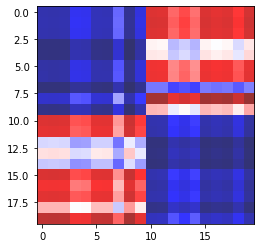

In [34]:
# Optimization Example: Rewiring wrt algebraic conectivity (on unnormalized Laplacian)

# Need to recompute e, evecs of unnormalized L during optimization. Over Graph argument
def unnormalized_laplacian_eigenvectors(G):
  n = G.number_of_nodes()
  Ldense = nx.laplacian_matrix(G).todense()
  # Finding eigen values and eigen vectors
  eL, evecsL = np.linalg.eig(Ldense)
  # Sort them (both e's and evecs's) ascending
  idx =eL.argsort()
  eL = eL[idx]
  evecsL = evecsL[:,idx]
  return eL, evecsL

def derivative_of_lambda2_wrt_adjacency(G): 
  n = G.number_of_nodes()
  eL, evecsL =  unnormalized_laplacian_eigenvectors(G)
  # Fiedler's value and vector
  lambda2 = eL[1]
  u2 = evecsL[:,1]
  # Construct the derivative matrix 
  u2u2T = np.matmul(u2,np.transpose(u2))
  #print(u2u2T[2,:])
  dl2 = np.matmul(np.diag(np.diag(u2u2T)),np.ones((n,n))) - u2u2T
  # Symmetrize and subtract the diag since it is an undirected graph
  #dl2 = dl2 + np.transpose(dl2) - np.diag(np.diag(dl2))
  return dl2

# Structure of the derivative: low values intra-class, higher values inter-class
# The derivative is governed by the Fiedler vector:
# u2u2T: each row is partitioned into positive and negative entries according to the clustering
# diag(u2u2T)*1nn: puts positive correlations in each row.
# diag(u2u2T)*1nn - u2u2T subtracts from positive correlations.
# dl2(i,j): is the deviation of the Fiedler vector info from the self-correlation. 
#          I.e. mis-classified nodes (low value of Fiedler entry will have large deviation)
 
dl2 = derivative_of_lambda2_wrt_adjacency(G)
print(np.diag(dl2))
print(dl2[2,:])
plt.imshow(dl2, alpha=0.8, cmap="seismic")

(20, 20)


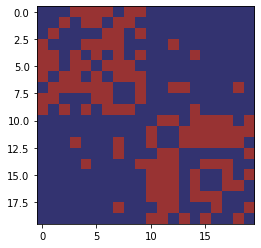

In [35]:
A = nx.adjacency_matrix(G).todense()
print(A.shape)
plt.imshow(A, alpha=0.8, cmap="seismic")

(20, 20)
0
[[ 2.42331104e+00  1.47440081e+00  1.42944275e+00  0.00000000e+00
   1.09600287e+00  2.23932720e+00  2.27111096e+00 -3.31640634e-04
   1.96596682e+00  3.68626634e-01 -7.17133293e+00 -7.09872121e+00
  -4.43688095e+00 -5.87918533e+00 -5.32113290e+00 -7.20731904e+00
  -6.94955201e+00 -7.12333493e+00 -6.13630220e+00 -7.46714254e+00]]
[[1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0]]


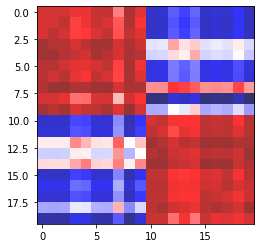

In [36]:
# If we apply derivatives without recalculating eigensystem we ACTUALLY DENSIFY the graph!
# We enlarge intra-class edges (fill the gaps)
# But inter-class edges are still active
mu = 0.1
lambdaReg =0.1
maxiter = 1000
Ac = np.copy(A)
print(A.shape)
print(Ac[0,2])
for k in range(maxiter):
  dl2 = derivative_of_lambda2_wrt_adjacency(G)
  Ac  = Ac - mu*dl2
plt.imshow(Ac, alpha=0.8, cmap="seismic")
print(Ac[3,:])
print(A[3,:])

(20, 20)
0
0.0
4.427897561947624
0.8185855996842306
0.0


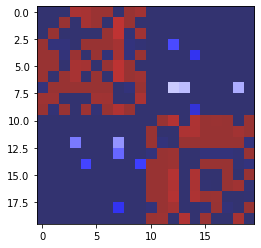

In [37]:
# If we apply derivatives WITH recalculating eigensystem....
import copy 

mu = 0.01
lambdaReg =20.0
maxiter = 100
inneriter = 10
Ac = np.copy(A)
print(A.shape)
dl2c = np.copy(dl2)
print(Ac[0,2])
Gc = copy.deepcopy(G)

cost_list=[]
lambda2_list = []
fiedler_list = []

def optimizing_lambda2_cost_function(A,Apred, lambda2):
  return np.linalg.norm(A-Apred) + lambdaReg*(lambda2**2)

def plot_input_list(input_list):  
  x = range(maxiter)
  y = np.asarray(input_list)
  plt.plot(x,y, 'r')
  # show the plot
  plt.show()

for k in range(maxiter):
  # Recalculate eigengap 
  eL, evecsL =  unnormalized_laplacian_eigenvectors(Gc)
  lambda2 = eL[1]

  # Compute dJ wrt A 
  # Inner loop to densify
  for l in range(inneriter):
   dl2c = derivative_of_lambda2_wrt_adjacency(Gc) 
   Ac  = Ac - mu*dl2c

  partialJ = 2*(Ac - A) + lambdaReg*2*lambda2*dl2c
  dJ = partialJ + np.transpose(partialJ) - np.diag(np.diag(partialJ))

  # Update adjacency
  Ac  = Ac - mu*dJ
  # Clipping: negatives to 0, positives to 1 
  Ac = np.clip(Ac,0,1)

  # Graph from adjacency matrix 
  Gc = nx.convert_matrix.from_numpy_matrix(Ac)

  # Update cost_list
  cost_list.append(optimizing_lambda2_cost_function(A, Ac, lambda2))
  lambda2_list.append(lambda2)
  fiedler_list.append(evecsL[:,1])
  

plt.imshow(Ac, alpha=0.8, cmap="seismic")
print(Ac[0,2])


print(optimizing_lambda2_cost_function(A,Ac, lambda2))
print(np.max(abs(Ac-A)))
print(np.min(abs(Ac-A)))

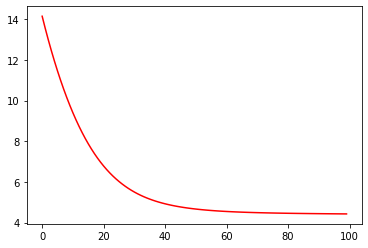

In [38]:
plot_input_list(cost_list)

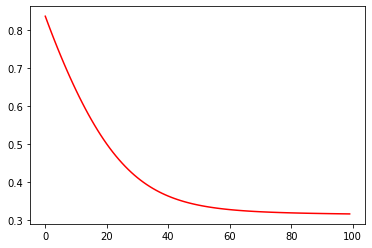

In [39]:
plot_input_list(lambda2_list)

In [40]:
print(fiedler_list[0])
print(fiedler_list[-1])

[[ 0.25351771]
 [ 0.25653022]
 [ 0.25387927]
 [ 0.16959223]
 [ 0.17525303]
 [ 0.24266911]
 [ 0.24454324]
 [ 0.1106077 ]
 [ 0.2855154 ]
 [ 0.19132828]
 [-0.25326518]
 [-0.24898363]
 [-0.15099328]
 [-0.17707374]
 [-0.1441682 ]
 [-0.2553871 ]
 [-0.24018788]
 [-0.25043498]
 [-0.19223463]
 [-0.27070759]]
[[-0.23571668]
 [-0.23551371]
 [-0.23498586]
 [-0.20465735]
 [-0.21042949]
 [-0.23143989]
 [-0.23213466]
 [-0.18189443]
 [-0.24537393]
 [-0.21700329]
 [ 0.234914  ]
 [ 0.23447594]
 [ 0.19201008]
 [ 0.20382302]
 [ 0.20052066]
 [ 0.23607405]
 [ 0.23211553]
 [ 0.23468208]
 [ 0.21935172]
 [ 0.24118223]]


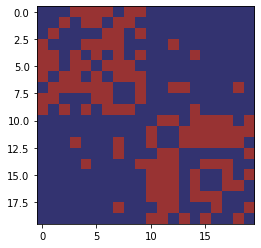

In [41]:
plt.imshow(A, alpha=0.8, cmap="seismic")

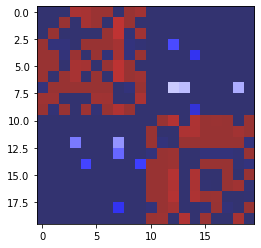

In [42]:
plt.imshow(Ac, alpha=0.8, cmap="seismic")

In [43]:
print(Ac[3,:])
print(A[3,:])

[[1.         0.02086219 0.02058541 0.         1.         1.
  1.         0.96639523 0.02530765 0.01061739 0.         0.
  0.27735775 0.         0.         0.         0.         0.
  0.         0.        ]]
[[1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0]]


In [44]:
print(Gc.edges)
print(G.edges)
print(nx.adjacency_matrix(Gc))
print(nx.adjacency_matrix(G))

[(0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (0, 1), (0, 2), (0, 7), (1, 2), (1, 4), (1, 5), (1, 7), (1, 8), (1, 3), (1, 6), (1, 9), (2, 6), (2, 7), (2, 8), (2, 9), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 14), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (7, 12), (7, 13), (7, 18), (8, 9), (9, 14), (10, 11), (10, 12), (10, 14), (10, 15), (10, 16), (10, 17), (10, 19), (10, 13), (10, 18), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (11, 12), (12, 13), (12, 14), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (15, 17), (15, 19), (15, 16), (15, 18), (16, 17), (16, 18), (16, 19), (17, 19), (17, 18), (18, 19)]
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (1, 2), (1, 4), (1, 5), (1, 7), (1, 8), (2, 6), (2, 7), (2, 9), (3, 4), (3, 5), (3, 6)

## 6. Convolutions in GNNs

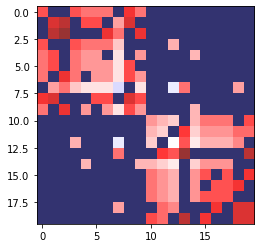

In [45]:
# Spatial convolution (Kipf & Welling)
n = nx.number_of_nodes(G)

# Get features from learned CT
X = Z

def select_k_indexes_and_set_zeros_in_features(X,k):
  sel = np.random.randint(2, size=n)
  Xcorrupted = X.copy()
  for i in range(n):
    if sel[i]==1: 
      Xcorrupted[i,0] = 0; 
      Xcorrupted[i,1] = 0; 
      Xcorrupted[i,2] = 0;
  return Xcorrupted

Xcorrupted = select_k_indexes_and_set_zeros_in_features(X,5)

# Compute the Ahat adjacency (normalized Atilde: A with self similarity)
def compute_ahat_adjacency(G): 
  A = nx.adjacency_matrix(G).todense()
  I = np.eye(n)
  Atilde = A + I # Self similarity added 
  d = np.sum(Atilde,axis=1) # Degrees
  d = np.squeeze(d)
  Dtilde = np.zeros((n,n))
  for i in range(n):
   Dtilde[i,i] = d[0,i]
  Dtilde = fractional_matrix_power(Dtilde, -0.5)
  Ahat = np.matmul(Dtilde,np.matmul(Atilde,Dtilde))
  return Ahat

Ahat = compute_ahat_adjacency(G)
plt.imshow(Ahat, alpha=0.8, cmap="seismic")

# A vanilla result of X diffusion on G 
fvanilla = np.matmul(Ahat,np.matmul(Ahat,Xcorrupted))

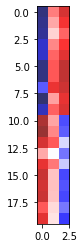

In [46]:
plt.imshow(Z, alpha=0.8, cmap="seismic")

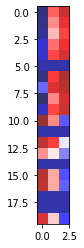

In [47]:
plt.imshow(Xcorrupted, alpha=0.8, cmap="seismic")

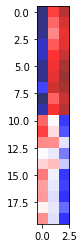

In [48]:
plt.imshow(fvanilla, alpha=0.8, cmap="seismic")

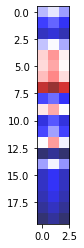

In [49]:
# Add to vanilla two weight matrices
W1 = np.random.rand(3,3)
W2 = np.random.rand(3,3)
X1 = np.matmul(np.matmul(Ahat,Xcorrupted),W1)
fweighted = np.matmul(np.matmul(A,X1),W2)

plt.imshow(fweighted, alpha=0.8, cmap="seismic")

[[-4.61559732e-01 -6.63344943e-01 -5.89253131e-01]
 [ 4.67993836e-01 -4.71491122e-02 -3.13659036e-01]
 [-1.25748052e-05  5.46750564e-06  3.26247264e-06]
 [-1.14713132e-06  3.59404122e-06 -3.18321336e-06]
 [-2.00003061e-06  4.21266063e-06 -3.19606094e-06]
 [-1.24928400e-07  4.59332696e-07 -4.26102191e-07]
 [-2.55425815e-08 -6.31844731e-08  8.91303451e-08]
 [-6.90880197e-08  7.43460130e-08 -2.98850910e-08]
 [ 6.14277983e-09 -1.51950026e-08  1.17590502e-08]
 [-1.66182980e-10 -1.99679682e-10  4.26316699e-10]
 [ 3.34489957e-10 -2.47107582e-10  3.63935132e-11]
 [-4.89968328e-10  7.71821524e-10 -4.85375323e-10]
 [-1.44556746e-10  2.20676244e-10 -1.41094543e-10]
 [ 4.28720164e-11 -7.30649642e-11  4.81538732e-11]
 [-1.32051559e-11  4.51361480e-11 -3.93191393e-11]
 [ 3.11930030e-12 -1.27638237e-11  1.12222808e-11]
 [-5.16791324e-12 -1.41741668e-12  5.59249228e-12]
 [-3.20286363e-12 -1.36447495e-11  1.82104121e-11]
 [-3.03716400e-13 -4.51192595e-13  7.32035741e-13]
 [ 3.62048289e-14 -1.08144406e-

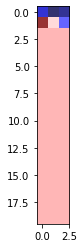

In [56]:
# Graph Fourier Transform for X 
Xhat = np.matmul(np.transpose(evecsNL),X)
plt.imshow(Xhat, alpha=0.8, cmap="seismic")
print(Xhat)


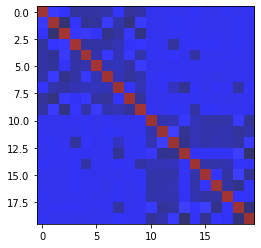

In [51]:
# Reconstruct Normalized Laplacian 
Lrecon = np.matmul(np.matmul(evecsNL,np.diag(e)),np.transpose(evecsNL))
plt.imshow(Lrecon, alpha=0.8, cmap="seismic")